In [1]:
from TS_HELPER import WindowGenerator

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('Google_Stock_Price.csv')

In [3]:
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1273,1/25/2017,829.62,835.77,825.06,835.67,"1,494,500"
1274,1/26/2017,837.81,838.00,827.01,832.15,"2,973,900"
1275,1/27/2017,834.71,841.95,820.44,823.31,"2,965,800"
1276,1/30/2017,814.66,815.84,799.80,802.32,"3,246,600"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 60.0+ KB


In [5]:
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
print(df.dtypes)

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [6]:

df['Date'] = pd.to_datetime(df['Date'])

In [7]:
date_time = pd.to_datetime(df.pop('Date'), format='%d-%m-%Y')

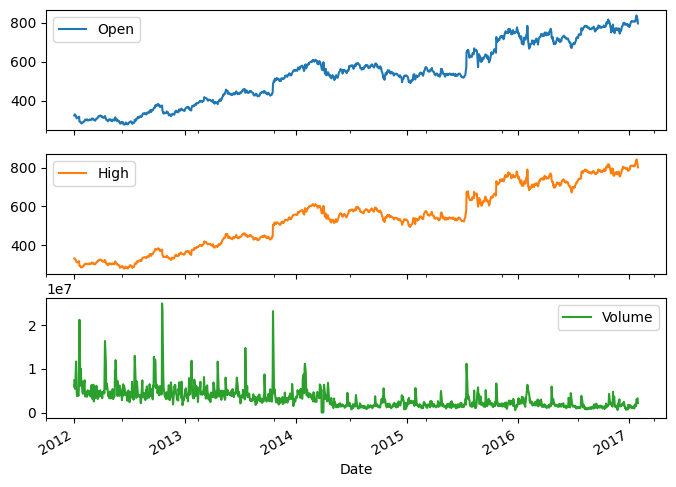

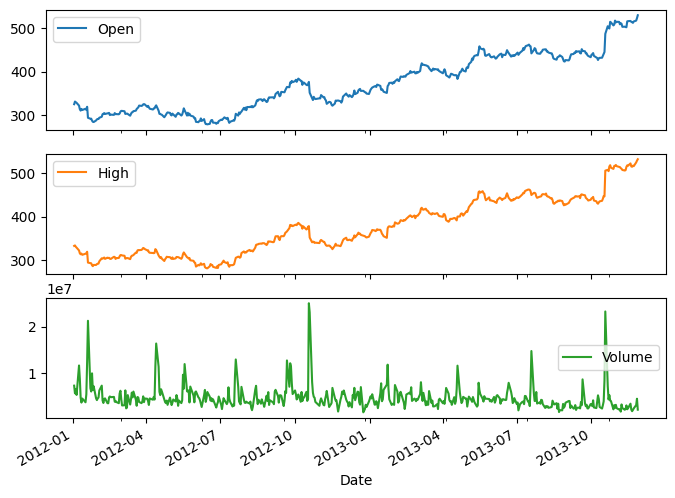

In [8]:
plot_cols = ['Open', 'High', 'Volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [9]:
df.describe()

,Open,High,Low,Close,Volume
count,1278.000000,1278.000000,1278.000000,1278.000000,1.278000e+03
mean,537.994906,542.168897,533.278803,714.160039,3.134661e+06
std,154.508365,155.582501,153.174011,163.892416,2.265015e+06
min,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,406.037500,408.230000,403.335000,578.412500,1.608700e+06
50%,538.395000,542.330000,534.355000,698.150000,2.528700e+06
75%,668.862500,677.705000,662.190000,785.572500,4.106200e+06
max,837.810000,841.950000,827.010000,1216.830000,2.497790e+07


## Split data

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
train_df.shape

(894, 5)

## Normalizing

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Single step

In [13]:
w1 = WindowGenerator(input_width=30, label_width=30, shift=1,
                     label_columns=['Open'],train_df=train_df,val_df=val_df,test_df=test_df)

In [14]:
w1

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Open']

In [27]:
lstm_single_step = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [28]:
def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    MAX_EPOCHS = 20
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs= MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [29]:
history = compile_and_fit(lstm_single_step , w1)

Epoch 1/20
27/27 [==============================] - 2s 25ms/step - loss: 0.1938 - mean_absolute_error: 0.3164 - val_loss: 0.9834 - val_mean_absolute_error: 0.9021
Epoch 2/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0627 - mean_absolute_error: 0.1680 - val_loss: 0.5497 - val_mean_absolute_error: 0.6264
Epoch 3/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0468 - mean_absolute_error: 0.1422 - val_loss: 0.3520 - val_mean_absolute_error: 0.4558
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0387 - mean_absolute_error: 0.1293 - val_loss: 0.2713 - val_mean_absolute_error: 0.3773
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0330 - mean_absolute_error: 0.1193 - val_loss: 0.2305 - val_mean_absolute_error: 0.3427
Epoch 6/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0283 - mean_absolute_error: 0.1104 - val_loss: 0.1899 - val_mean_absolute_error: 0.2979
Epoch 7/20
27/27 [=========

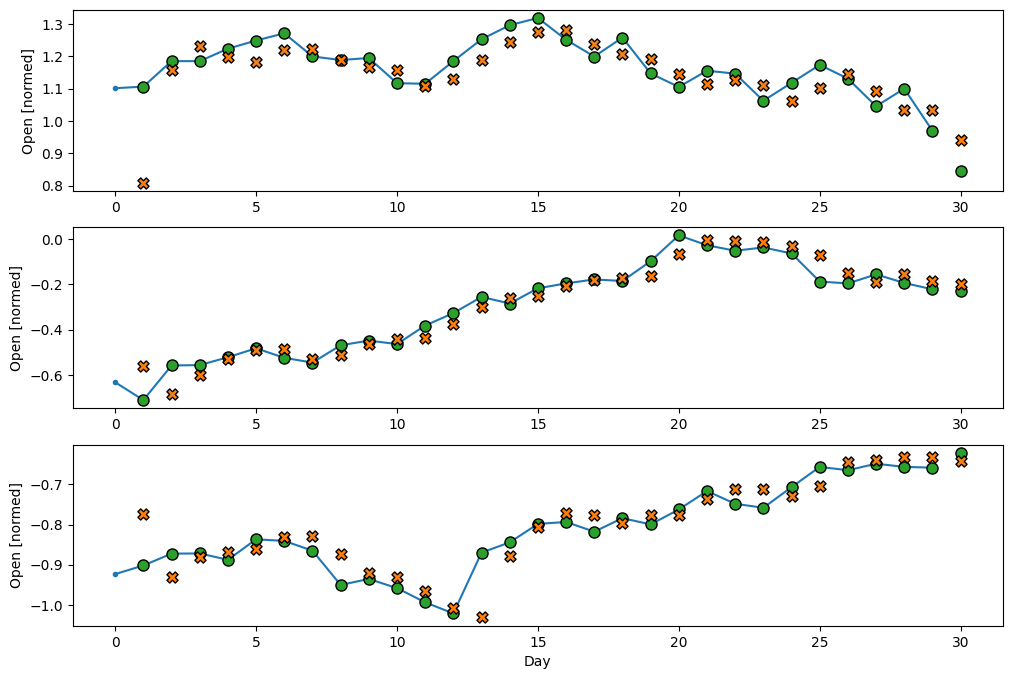

In [30]:
w1.plot(model = lstm_single_step, plot_col= 'Open')

In [31]:
train_loss_single = history.history['loss']
val_loss_single = history.history['val_loss']

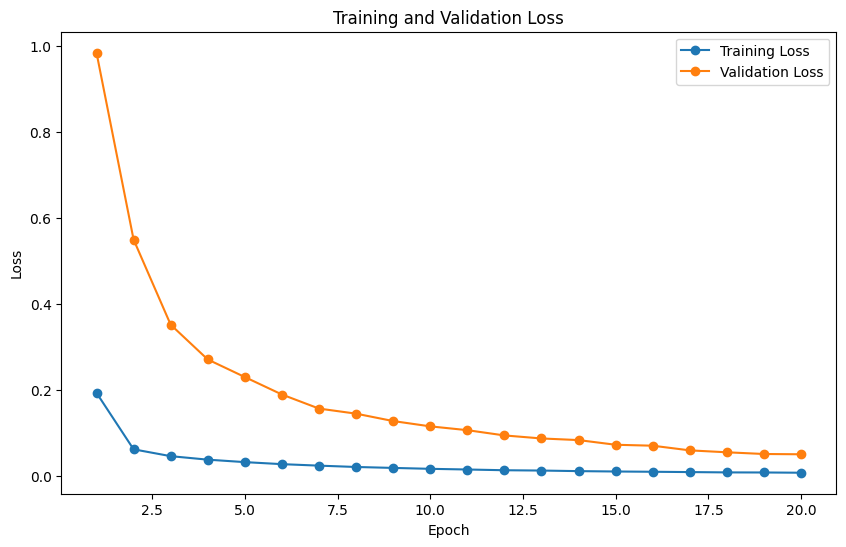

In [32]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_loss_single) + 1)
plt.plot(epochs, train_loss_single, label='Training Loss', marker='o')
plt.plot(epochs, val_loss_single, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Multi Step

In [34]:
w2 = WindowGenerator(input_width=30, label_width=30, shift=30,
                     label_columns=['Open'],train_df=train_df,val_df=val_df,test_df=test_df)

In [46]:
lstm_multi_step = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [47]:
history3 = compile_and_fit(lstm_multi_step , w2)

Epoch 1/20
27/27 [==============================] - 2s 26ms/step - loss: 0.2345 - mean_absolute_error: 0.3752 - val_loss: 1.6384 - val_mean_absolute_error: 1.2108
Epoch 2/20
27/27 [==============================] - 0s 11ms/step - loss: 0.1252 - mean_absolute_error: 0.2792 - val_loss: 1.4992 - val_mean_absolute_error: 1.1599
Epoch 3/20
27/27 [==============================] - 0s 10ms/step - loss: 0.1094 - mean_absolute_error: 0.2630 - val_loss: 1.5878 - val_mean_absolute_error: 1.2047
Epoch 4/20
27/27 [==============================] - 0s 8ms/step - loss: 0.1011 - mean_absolute_error: 0.2532 - val_loss: 1.8894 - val_mean_absolute_error: 1.3275
Epoch 5/20
27/27 [==============================] - 0s 8ms/step - loss: 0.0921 - mean_absolute_error: 0.2425 - val_loss: 2.1068 - val_mean_absolute_error: 1.4041


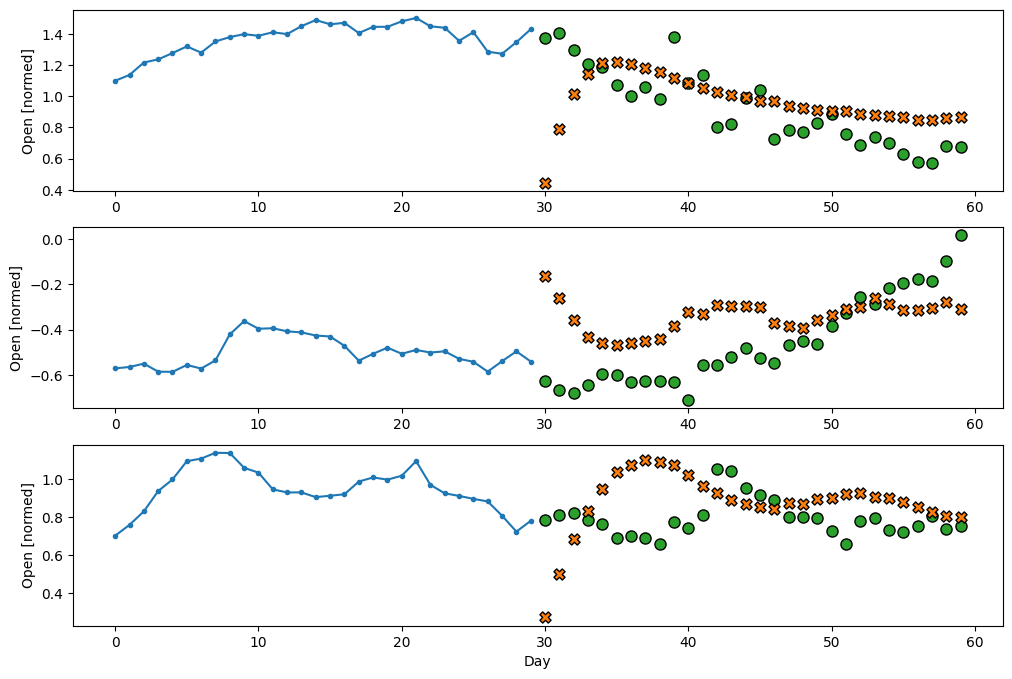

In [48]:
w2.plot(model = lstm_multi_step, plot_col= 'Open')

In [49]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

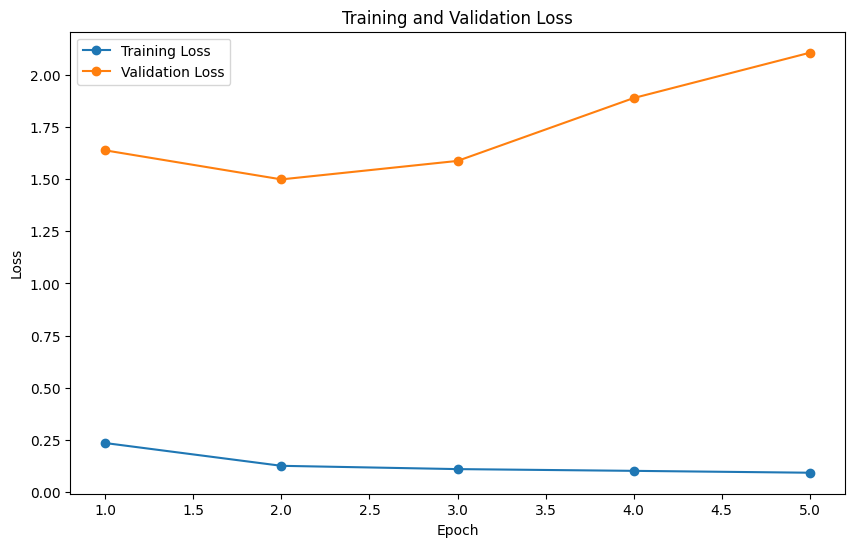

In [50]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()